# EDA and Viz

In this notebook I am to explore the datasets further and produce some visualisations. 

In [131]:
# imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from surprise import Reader, Dataset

parent_dir = '../../../'

In [188]:
# plot parameters
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'white' # or EAEAF2

### Movies df:

In [2]:
movies = pd.read_csv(parent_dir + 'data/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
movieId    9742 non-null int64
title      9742 non-null object
genres     9742 non-null object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


So from here we assume there are 9742 unique movies. But let's check the unique titles:

In [9]:
len(movies['title'].unique())

9737

This doesn't agree with the 9742 we saw earlier.  

In [10]:
len(movies['movieId'].unique())

9742

So there are 9742 unique movieId's but only 9737 unique titles.  This means some movies have 2 different movieIds.  Let's see if we can isolate these movies (there are only 5).  

Test:

In [25]:
test = {}
ls = ['h', '3', '3', 'l', 't', '2', 't', 't']
for l in ls:
    test[l] = test.get(l, 0) + 1
test

{'h': 1, '3': 2, 'l': 1, 't': 3, '2': 1}

In [26]:
for t in test:
    if test[t] > 1:
        print(t)

3
t


In [21]:
count_movies = {}
for title in movies['title']:
#     print(movie)
    count_movies[title] = count_movies.get(title, 0) + 1
len(count_movies)

9737

In [32]:
double_movies = []
for title in count_movies:
    if count_movies[title] > 1:
        print(title, count_movies[title])
        double_movies.append(title)

Emma (1996) 2
Saturn 3 (1980) 2
Confessions of a Dangerous Mind (2002) 2
Eros (2004) 2
War of the Worlds (2005) 2


In [33]:
double_movies

['Emma (1996)',
 'Saturn 3 (1980)',
 'Confessions of a Dangerous Mind (2002)',
 'Eros (2004)',
 'War of the Worlds (2005)']

In [34]:
movies[movies['title'].isin(double_movies)]

,movieId,title,genres
650,838,Emma (1996),Comedy|Drama|Romance
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller
5601,26958,Emma (1996),Romance
5854,32600,Eros (2004),Drama
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
6932,64997,War of the Worlds (2005),Action|Sci-Fi
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
9135,147002,Eros (2004),Drama|Romance
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller


In [38]:
for title in double_movies:
    print(movies[movies['title'] == title])

      movieId        title                genres
650       838  Emma (1996)  Comedy|Drama|Romance
5601    26958  Emma (1996)               Romance
      movieId            title                     genres
2141     2851  Saturn 3 (1980)  Adventure|Sci-Fi|Thriller
9468   168358  Saturn 3 (1980)            Sci-Fi|Thriller
      movieId                                   title  \
4169     6003  Confessions of a Dangerous Mind (2002)   
9106   144606  Confessions of a Dangerous Mind (2002)   

                                   genres  
4169          Comedy|Crime|Drama|Thriller  
9106  Comedy|Crime|Drama|Romance|Thriller  
      movieId        title         genres
5854    32600  Eros (2004)          Drama
9135   147002  Eros (2004)  Drama|Romance
      movieId                     title                            genres
5931    34048  War of the Worlds (2005)  Action|Adventure|Sci-Fi|Thriller
6932    64997  War of the Worlds (2005)                     Action|Sci-Fi


I'm going to drop the rows where the genre is only a subset of the duplicate's list of genres.  E.g., I'll drop row 5601 because it only has 'Romance' whereas Romance is included in row 650 of the 'Emma' movie.  

Since there are only 5 rows to drop, I'll manually make a list of their index's to drop them. 

In [40]:
rows_to_drop = [5601, 9468, 4169, 5854, 6932]
movies = movies.drop(rows_to_drop, axis = 0)

Test that it worked as expected:

In [41]:
count_movies_again = {}
for title in movies['title']:
#     print(movie)
    count_movies_again[title] = count_movies_again.get(title, 0) + 1
len(count_movies_again)

9737

In [42]:
double_movies_again = []
for title in count_movies_again:
    if count_movies_again[title] > 1:
        print(title, count_movies_again[title])
        double_movies_again.append(title)

In [43]:
len(double_movies_again)

0

Awesome

Interested to see how many unique genre combinations we have:

In [45]:
len(movies['genres'].unique())

951

In [49]:
count_genres = {}
for genre in movies['genres']:
    count_genres[genre] = count_genres.get(genre, 0) + 1

So there are 951 unique genre combinations.  Let's see how many of these only have 1 movie classified as this combination of genres.  Perhaps these are 'less common' or more 'out-there' movies.  Or perhaps their genre could be reduced to be more generalisable.  

This is important because we loose information about people who like movies of the same genre, but if someone is classified as 'not alike' just because a genre combination of their favourite movie was 'Adventure|Children|Romance' and another person's was 'Adventure|Children|Romance|IMAX', this could loose valuable information about those people.  

Perhaps we'll need to make sure 'genre' is handled appropritely and that our model features include the different types of genres included in combination genres. 


In [54]:
only_one = []
for genre in count_genres:
    if count_genres[genre] == 1:
        print(genre, count_genres[genre])
        only_one.append(genre)
print(len(only_one))

Crime|Drama|Horror|Mystery|Thriller 1
Adventure|Drama|Fantasy|Mystery|Sci-Fi 1
Action|Adventure|Mystery|Sci-Fi 1
Action|Romance|Western 1
Fantasy|Horror|Mystery 1
Action|Crime|Drama|Mystery|Sci-Fi|Thriller 1
Adventure|Comedy|Crime|Mystery 1
Adventure|Children|Comedy|Fantasy|Romance 1
Drama|Romance|War|Western 1
Children|Drama|Fantasy|Mystery 1
Action|Crime|Fantasy|Thriller 1
Adventure|Children|Romance 1
Adventure|Animation|Children|Drama|Musical|IMAX 1
Action|Adventure|Crime|Drama|Romance|Thriller 1
Action|Children|Romance 1
Action|Adventure|Children|Comedy|Fantasy|Sci-Fi 1
Action|Adventure|Animation|Children|Fantasy 1
Comedy|Drama|Fantasy|Romance|Thriller 1
Animation|Children|Drama|Fantasy|Musical 1
Animation|Children|Fantasy|Musical|Romance|IMAX 1
Action|Adventure|Animation|Horror|Sci-Fi 1
Action|Crime|Drama|War 1
Drama|Mystery|Romance|Sci-Fi|Thriller 1
Comedy|Fantasy|Romance|Sci-Fi 1
Comedy|Fantasy|Musical 1
Crime|Drama|Musical|Thriller 1
Adventure|Drama|Romance|War 1
Action|Adventu

Let's look into the most common genres and find the top tend genre combinations (that is, the genre with the most amount of movies listed as this genre).

In [68]:
popular_genre = []
for genre in count_genres:
    if count_genres[genre] > 100:
        print(genre, count_genres[genre])
        popular_genre.append(genre)
print(len(popular_genre))

Comedy|Romance 363
Comedy|Drama|Romance 276
Comedy 946
Drama 1052
Crime|Drama 134
Drama|Romance 349
Drama|War 114
Drama|Thriller 168
Comedy|Crime 101
Comedy|Drama 435
Documentary 339
Crime|Drama|Thriller 125
Horror 167
Horror|Thriller 135
14


In [69]:
sorted_pop_genres = sorted(lots_of_genre, key=lambda x:x[1], reverse=True)

In [70]:
sorted_pop_genres[:10]

['Drama',
 'Crime|Drama',
 'Drama|Romance',
 'Drama|War',
 'Drama|Thriller',
 'Crime|Drama|Thriller',
 'Comedy|Romance',
 'Comedy|Drama|Romance',
 'Comedy',
 'Comedy|Crime']

From this list, we can see that there's pretty much 3 genres that the top movies boil down to:
- Drama
- Crime/Thriller
- Comedy 

We'll need to make sure we're filtering by unique combinations and maybe we can extract the single-use genre combinations and get rid of their unique extra genre?

I'll think more on this later how to deal with this when I get to using this df in models...

For now, I'll read out the df I have that dropped those duplicate rows:

In [197]:
movies_dropped = movies.to_csv(parent_dir + 'data/mod_movies_lc')

### Ratings df:

In [71]:
ratings = pd.read_csv(parent_dir + 'data/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Check how many unique movies we have (should maybe make sure the same double up from the movie df isn't occuring here and make sure we haven't dropped those movies).

In [85]:
len(ratings.movieId.unique())

9724

Check how many unique ratings we have to make sure we don't have any weird values

In [83]:
len(ratings.rating.unique())

10

In [84]:
ratings.rating.unique()

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

All these numbers are as expected.

In [72]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
userId       100836 non-null int64
movieId      100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


While I won't use the timestamp column for modelling (this will be dropped), I do want to see if there's anything going on with timeseries for this column:

In [76]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'])
ratings.set_index('timestamp', inplace=True)

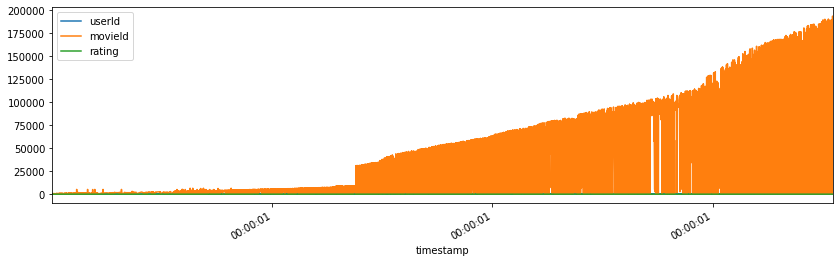

In [87]:
ratings.plot(figsize = (14,4))
plt.show();

The time axis is meaningless here...

In [80]:
ratings.head()

,userId,movieId,rating
timestamp,,,
1970-01-01 00:00:00.964982703,1,1,4.0
1970-01-01 00:00:00.964981247,1,3,4.0
1970-01-01 00:00:00.964982224,1,6,4.0
1970-01-01 00:00:00.964983815,1,47,5.0
1970-01-01 00:00:00.964982931,1,50,5.0


In [97]:
ratings_month_df = ratings.resample('Y').mean()

In [98]:
ratings_month_df.head()

,userId,movieId,rating
timestamp,,,
1970-12-31,326.127564,19435.295718,3.501557


Feeling like this is a little meaningless... let's go back to the normal dataframe... will just read it in again.

In [100]:
ratings = pd.read_csv(parent_dir + 'data/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


How many users do we have in this dataset?

In [102]:
len(ratings.userId.unique())

610

What's the average rating?

In [103]:
ratings.rating.mean()

3.501556983616962

So a just higher than average rating. 

Let's look into the distribution of the ratings:

In [104]:
count_ratings = {}
for rating in ratings['rating']:
    count_ratings[rating] = count_ratings.get(rating, 0) + 1
count_ratings

{4.0: 26818,
 5.0: 13211,
 3.0: 20047,
 2.0: 7551,
 1.0: 2811,
 4.5: 8551,
 3.5: 13136,
 2.5: 5550,
 0.5: 1370,
 1.5: 1791}

Plot this:

In [186]:
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'white' # or EAEAF2

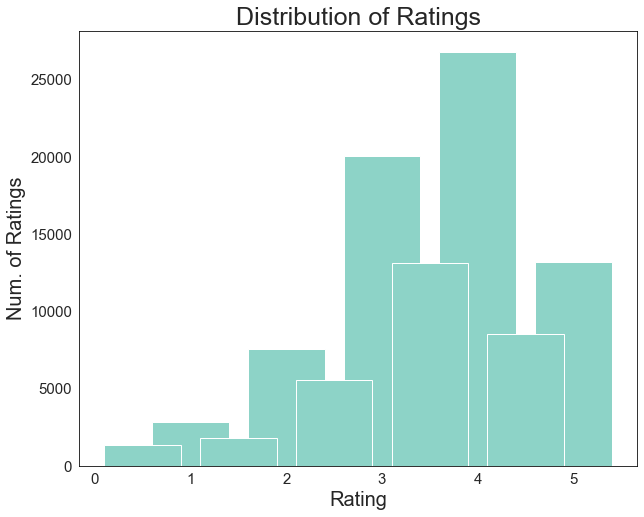

In [187]:
plt.subplots(figsize = (10, 8))
plt.bar(count_ratings.keys(), count_ratings.values())
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Num. of Ratings')
plt.show();

We can see from this bar graph that the ratings data is left skewed and that there aren't as many ratings below 3 in this dataset.  Perhaps this says something about the motivation for people to rate movies - perhaps people don't bother if the movie is shit...

In [132]:
plt.rcParams

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/lib/pretty.py:697: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  output = repr(obj)


RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#EAEAF2',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

In [189]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Now, we really don't need timestamp for modelling so we will remove this.

In [191]:
ratings.drop('timestamp', axis = 1, inplace = True)

In [192]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


Read this df out so it's accessible later:

In [194]:
ratings_model = ratings.to_csv(parent_dir + 'data/mod_ratings_lc')

### Links df:

In [5]:
links = pd.read_csv(parent_dir + 'data/links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [198]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
movieId    9742 non-null int64
imdbId     9742 non-null int64
tmdbId     9734 non-null float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


It looks like there are going to be duplicates again given that there are the same number of movie_Id's that the movies df had... so let's see if there are duplicate imdbIds:

In [199]:
len(links.movieId.unique())

9742

In [200]:
len(links.imdbId.unique())

9742

Ok no, doesn't look like there are duplicates but let's check using the duplicates method:

In [203]:
links.duplicated().sum()

0

Looks like we're safe.

Check the na's for tmdbId:

In [201]:
len(links.tmdbId.unique())

9734

In [205]:
links.isna().sum()

movieId    0
imdbId     0
tmdbId     8
dtype: int64

In [206]:
links[links['tmdbId'].isna()]

,movieId,imdbId,tmdbId
624,791,113610,NaN
843,1107,102336,NaN
2141,2851,81454,NaN
3027,4051,56600,NaN
5532,26587,92337,NaN
5854,32600,377059,NaN
6059,40697,105946,NaN
7382,79299,874957,NaN


I think it's fine that we're missing tmdbIds...

### Tags df:

In [4]:
tags = pd.read_csv(parent_dir + 'data/tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [207]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
userId       3683 non-null int64
movieId      3683 non-null int64
tag          3683 non-null object
timestamp    3683 non-null int64
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


No null rows.

In [208]:
len(tags.userId.unique())

58

In [209]:
len(tags.movieId.unique())

1572

In [210]:
len(tags.tag.unique())

1589

So while there are 3683 entries, there are only 1589 unique tags so we do have some common tags - might be worth finding the top 10-20 most common tags perhaps?

Only 1572 movies have been tagged so if we join these dfs, most will have na values (which is fine).

Only 58 users actually add tags.  Small subset.

We probably don't need the timestamp column for this dataset.

In [211]:
tags.drop('timestamp', axis = 1, inplace = True)

In [212]:
tags.head()

,userId,movieId,tag
0,2,60756,funny
1,2,60756,Highly quotable
2,2,60756,will ferrell
3,2,89774,Boxing story
4,2,89774,MMA


In [217]:
count_tags = {}
for tag in tags['tag']:
    count_tags[tag] = count_tags.get(tag, 0) + 1

Let's look into the most common tags and find the top 20 tags.

In [219]:
popular_tag = []
for tag in count_tags:
    if count_tags[tag] > 0:
#         print(genre, count_genres[tag])
        popular_tag.append(tag)
print(len(popular_tag))

1589


In [220]:
sorted_pop_tags = sorted(popular_tag, key=lambda x:x[1], reverse=True)

In [222]:
sorted_pop_tags[:20]

['cyberpunk',
 'Mystery',
 'Ryan Reynolds',
 'dystopia',
 'ryan reynolds',
 'Dystopia',
 'system holism',
 'mystery',
 'cynical',
 'mythology',
 'Myth',
 'lyrical',
 'symbolism',
 'symbolic',
 'Exquisite plotting.',
 'ex-con',
 'existentialism',
 'Existential',
 'exciting',
 'twist ending']

We can see there's a lot of double ups here with tags that do and don't use capitilisation such asa 'Ryan Reynolds' vs. 'ryan reynolds'.  As well as similar categories such as 'myth', 'mythology', even 'mystery'.  

Perhaps we could perform some NLP pre-processing on this data to make more consistent tags.  This might not be completely neccessary since it's such a small set of the data that is tagged (only 3000 amongst 100k movie ratings) but something we could experiment with.  

I won't do any of the NLP processing now, but we know it exists and I will export the csv without the timestamp.

In [223]:
tags_model = tags.to_csv(parent_dir + 'data/mod_tags_lc')

# Join the dataframes:

The `ratings` df has over 100k rows, and then `movies` df has just under 10k rows.  So let's first try joining the `ratings` and `movies` dfs together using `movieId` as the key.  We will left join on `ratings`.

First, we'll check the shape of both dfs to be able to compare the joined result.  

In [224]:
ratings.shape

(100836, 3)

In [225]:
movies.shape

(9737, 3)

In [227]:
movie_ratings = ratings.set_index('movieId').join(movies.set_index('movieId'))

In [230]:
movie_ratings.head()

,userId,rating,title,genres
movieId,,,,
1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,7,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,15,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,17,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


This is looking like our desired result.  Let's check the shape:

In [231]:
movie_ratings.shape

(100836, 4)

So we have not lost rows - this is what we expect. 

In [234]:
movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 1 to 193609
Data columns (total 4 columns):
userId    100836 non-null int64
rating    100836 non-null float64
title     100816 non-null object
genres    100816 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 3.8+ MB


From here we can see that there are 20 movies that we do not know the title or genre for.  Let's see what these movies are:

In [237]:
movie_ratings[movie_ratings['title'].isna()]

,userId,rating,title,genres
movieId,,,,
6003,111,4.0,NaN,NaN
6003,156,3.5,NaN,NaN
6003,182,3.0,NaN,NaN
6003,288,4.0,NaN,NaN
6003,356,4.5,NaN,NaN
6003,387,3.5,NaN,NaN
6003,414,3.5,NaN,NaN
6003,474,3.5,NaN,NaN
6003,480,3.5,NaN,NaN


From here, out of the 20 that do not have titles or genres, there are actually only 5 movies that are missing their title.  We could pair this with the links df and look up the title and genre on IMDB and manually add this in since it's only 5 records.  This might be worth it since movie 6003 has 15 ratings that we don't know the name of (and hence can't recommend the name in our app). 

Let's now join the links df with this df, again with the movie id as the key:

In [239]:
links.shape

(9742, 3)

In [244]:
movie_rating_links = movie_ratings.join(links.set_index('movieId'))

In [245]:
movie_rating_links.head()

,userId,rating,title,genres,imdbId,tmdbId
movieId,,,,,,
1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,5,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,7,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,15,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,17,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0


In [246]:
movie_rating_links.shape

(100836, 6)

No info loss! 

Let's have a look at those movies that didn't have titles:

In [247]:
movie_rating_links[movie_rating_links['title'].isna()]

,userId,rating,title,genres,imdbId,tmdbId
movieId,,,,,,
6003,111,4.0,NaN,NaN,290538,4912.0
6003,156,3.5,NaN,NaN,290538,4912.0
6003,182,3.0,NaN,NaN,290538,4912.0
6003,288,4.0,NaN,NaN,290538,4912.0
6003,356,4.5,NaN,NaN,290538,4912.0
6003,387,3.5,NaN,NaN,290538,4912.0
6003,414,3.5,NaN,NaN,290538,4912.0
6003,474,3.5,NaN,NaN,290538,4912.0
6003,480,3.5,NaN,NaN,290538,4912.0


Perhaps I could try tapping into the IMDB API to get the title and genre from the website.

Let's now join the tags df to now have all our dfs joined.

In [250]:
tags.head()

,userId,movieId,tag
0,2,60756,funny
1,2,60756,Highly quotable
2,2,60756,will ferrell
3,2,89774,Boxing story
4,2,89774,MMA


In [249]:
movie_rating_links.join(tags.set_index('movieId'))

ValueError: columns overlap but no suffix specified: Index(['userId'], dtype='object')

Got an error doing this so will actually need to merge these dfs...

In [251]:
movie_rating_links.shape

(100836, 6)

In [252]:
tags.shape

(3683, 3)

In [256]:
movie_rating_links.merge(tags, on = 'movieId', how = 'left')

,movieId,userId_x,rating,title,genres,imdbId,tmdbId,userId_y,tag
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,336.0,pixar
1,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,474.0,pixar
2,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,567.0,fun
3,1,5,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,336.0,pixar
4,1,5,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,474.0,pixar
...,...,...,...,...,...,...,...,...,...
285757,193581,184,4.0,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,5476944,432131.0,NaN,NaN
285758,193583,184,3.5,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,5914996,445030.0,NaN,NaN
285759,193585,184,3.5,Flint (2017),Drama,6397426,479308.0,NaN,NaN
285760,193587,184,3.5,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,8391976,483455.0,NaN,NaN


This is not what I wanted...

It looks like maybe I'll have to join using `userId` as the key... let's try this...

In [258]:
movie_rating_links.set_index('userId').join(tags.set_index('userId'))

,rating,title,genres,imdbId,tmdbId,movieId,tag
userId,,,,,,,
1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,NaN,NaN
1,4.0,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0,NaN,NaN
1,4.0,Heat (1995),Action|Crime|Thriller,113277,949.0,NaN,NaN
1,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,114369,807.0,NaN,NaN
1,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,114814,629.0,NaN,NaN
...,...,...,...,...,...,...,...
610,5.0,Logan (2017),Action|Sci-Fi,3315342,263115.0,3265.0,heroic bloodshed
610,5.0,Logan (2017),Action|Sci-Fi,3315342,263115.0,168248.0,Heroic Bloodshed
610,3.0,The Fate of the Furious (2017),Action|Crime|Drama|Thriller,4630562,337339.0,3265.0,gun fu


Most certainly not what I was expecting...

I just want it to throw in the tags to the movie it's asociated with... 

Oh but the problem is that a particular person made that tag so i have to match the userId and the movieId... so need a 'secondary key' situation.. not sure how to do that yet... will look into that...

After investigating it, it looks like you merge the dfs but you enter a list of keys to merge 'on':

In [261]:
movie_rating_links.merge(tags, on = ['movieId', 'userId'], how = 'left')

,movieId,userId,rating,title,genres,imdbId,tmdbId,tag
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,NaN
1,1,5,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,NaN
2,1,7,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,NaN
3,1,15,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,NaN
4,1,17,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,NaN
...,...,...,...,...,...,...,...,...
102672,193581,184,4.0,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,5476944,432131.0,NaN
102673,193583,184,3.5,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,5914996,445030.0,NaN
102674,193585,184,3.5,Flint (2017),Drama,6397426,479308.0,NaN
102675,193587,184,3.5,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,8391976,483455.0,NaN


This is closer to what I was expecting but not sure why I have extra rows now... perhaps tags had movies that were not in the movies df?  Let's check that...

In [262]:
movies.movieId.unique() == tags.movieId.unique()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

In [263]:
len(movies.movieId.unique())

9737

In [264]:
len(tags.movieId.unique())

1572

In [265]:
for movie in tags.movieId.unique():
    if movie not in movies.movieId.unique():
        print(movie)

6003


Of course... the movie that mad missing titles and genres... but there were only 20 of those and this merge has added 1841 extra rows.... will have to look into this further.  For now, I'm going for a walk!

Let's save the latested merged df that makes sense to a csv:

In [266]:
movie_rating_link = movie_rating_links.to_csv(parent_dir + 'data/joined_dfs_lc')